<img src="https://github.com/d9w/evolution/raw/master/imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Algorithms

## Covariance Matrix Adaptation Evolutionary Strategy

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

Covariance Matrix Adaptation Evolutionary Strategy, or CMA-ES [1, 2], is one of the most well-known evolutionary algorithms in general and is a state-of-the-art algorithm for continuous optimization. The strength of this method is that it adapts the distribution it uses to generate the next population based on the current distribution of individuals. Until now, we were limited to a Normal distribution with a static $\sigma$. The adaptive distribution of CMA-ES means it will cross search spaces faster and narrow in more exactly on optimal points.

[1] Hansen, Nikolaus, and Andreas Ostermeier. "Adapting arbitrary normal mutation distributions in evolution strategies: The covariance matrix adaptation." Proceedings of IEEE international conference on evolutionary computation. IEEE, 1996.

[2] Hansen, Nikolaus, and Andreas Ostermeier. "Completely derandomized self-adaptation in evolution strategies." Evolutionary computation 9.2 (2001): 159-195.

Specifically, the things that CMA-ES improves over the previous Evolutionary Strategies we've seen is that it:
+ combines information from multiple individuals (as in $(\mu, \lambda)$ and Canonical ES)
+ combines information from multiple generations
+ transforms the distribution of the new population to match the search space
+ adapts the step size to prevent premature convergence

One improvement in CMA-ES which we've already seen is the use of **fitness rank** instead of direct fitness for the update. However, instead of directly updating a centroid, CMA-ES updates a covariance matrix.

CMA-ES uses two principles to achieve this: maximum likelihood estimation and step-size control. We'll start with maximum likelihood estimation, which consists of increasing the probability of successful points. CMA-ES will update the population center by taking the weighted average of high-fitness individuals.

<div class="alert alert-success">
    <h3>Exercise 1</h3>
    
CMA-ES has been widely used in many applications. Discuss one of the following application papers in your group. What is the application? How is the problem encoded in a way that CMA-ES can solve it? Is CMA-ES compared to other methods and if so, how does it do?
    
+ [Gagné, C., Beaulieu, J., Parizeau, M., & Thibault, S. (2008). Human-competitive lens system design with evolution strategies. Applied Soft Computing, 8(4), 1439-1452.](http://www.genetic-programming.org/hc2007/06-Gagne/Gagne-RT-LVSN-2007-01.pdf)
+ [Bayer, P., & Finkel, M. (2007). Optimization of concentration control by evolution strategies: Formulation, application, and assessment of remedial solutions. Water resources research, 43(2).](https://www.academia.edu/download/42649750/Optimization_of_concentration_control_by20160213-31306-8zy30l.pdf)
+ [Kämpf, J. H., & Robinson, D. (2009). A hybrid CMA-ES and HDE optimisation algorithm with application to solar energy potential. Applied Soft Computing, 9(2), 738-745.](https://www.sciencedirect.com/science/article/pii/S1568494608001336?casa_token=w27xSjQ0zY8AAAAA:6XzGZ73KLEsXGbj5m7YE4LgZ1zCm5sQhQP8I2Zx6XH-HPP5PmfF5VO3d1pu7fXSn2jh97cN9AdU)
+ [Maki, A., Sakamoto, N., Akimoto, Y., Nishikawa, H., & Umeda, N. (2020). Application of optimal control theory based on the evolution strategy (CMA-ES) to automatic berthing. Journal of Marine Science and Technology, 25(1), 221-233.](https://link.springer.com/article/10.1007/s00773-019-00642-3)
+ [Loshchilov, I., & Hutter, F. (2016). CMA-ES for hyperparameter optimization of deep neural networks. arXiv preprint arXiv:1604.07269.](https://openreview.net/pdf/xnrA4qzmPu1m7RyVi38Z.pdf)
+ [Fukagata, K., Kern, S., Chatelain, P., Koumoutsakos, P., & Kasagi, N. (2008). Evolutionary optimization of an anisotropic compliant surface for turbulent friction drag reduction. Journal of Turbulence, (9), N35.](http://www.cse-lab.ethz.ch/wp-content/papercite-data/pdf/fukagata2008a.pdf)
</div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
import numpy as np
import math
import matplotlib.animation as animation
from IPython import display

In [2]:
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

In [3]:
def rosenbrock(x, y, a=1, B=100):
      return (a-x)**2 + B*((y-x**2))**2

In [4]:
def rastrigin(X, Y):
    Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
      (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
    return Z

In [5]:
def rastrigin_shifted(X, Y, a=0.3, b=1.2, c=0.6, d=2.9):
    X = a*X + b
    Y = c*Y + d
    Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
      (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
    return Z

In [6]:
optf = himmelblau

In [7]:
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = optf(X, Y)

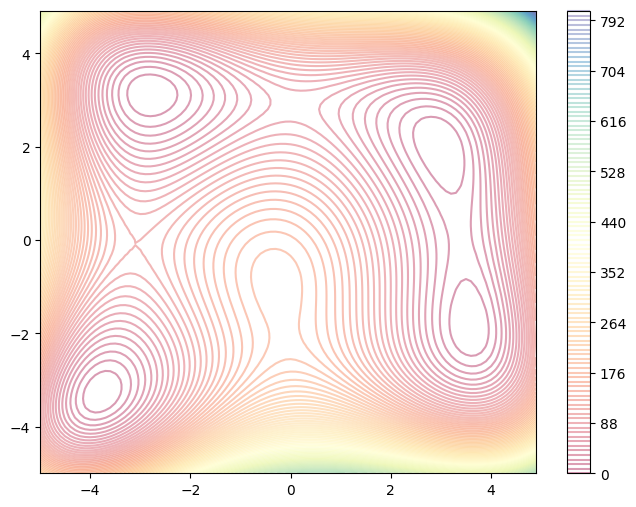

In [8]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
fig.colorbar(cs)
plt.show()

## Covariance Matrix Update

First, we select the top $\mu$ individuals based on their fitness values. We'll then weight their importance by their fitness rank, using a static weight vector $w$. This weight vector $w$ is a hyperparameter in CMA-ES, but there is a standard normalized logarithmic weight scale used by most. Note that the weight is not their fitness values but rather just the rank. This has been demonstrated to aid in search in ill-formed search spaces.

In [9]:
np.random.seed(0)
lam = 70
x = np.random.rand(2) * 5 - 2.5
N = np.random.normal(size=(lam,2)) * 0.5
x_t = x + N
fits = optf(x_t[:, 0], x_t[:, 1])

In [10]:
mu = 10
sorted_ids = np.argsort(fits)
w = np.log(mu + 1/2) - np.log(np.arange(1, mu+1))
w /= np.sum(w)
weighted = N[sorted_ids[:mu]] * w.reshape(mu, 1)
s = np.mean(weighted, axis=0)
s

array([0.06372473, 0.08254817])

This $s$ direction vector is similar to the gradient estimation from the last exercise. However, in CMA-ES, only the top $\mu$ individuals are used to calculate $s$, and instead of directly using fitness values, $s$ is calculated using weight based on fitness rank. We can compare the two vectors.

In [11]:
A = (fits - np.mean(fits)) / np.std(fits)
G = -np.dot(A, N) / lam

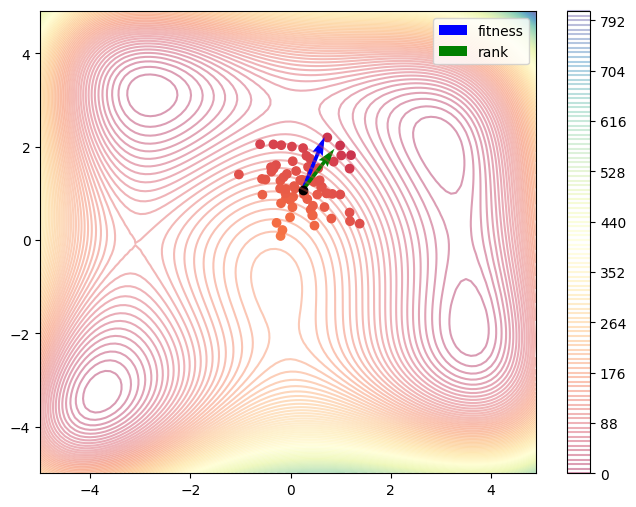

In [12]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.scatter(x_t[:, 0], x_t[:, 1], c=fits, cmap='Spectral', norm=norm)
plt.quiver(x[0], x[1], G[0], G[1], color='b', scale=4, label='fitness')
plt.quiver(x[0], x[1], s[0], s[1], color='g', scale=1, label='rank')
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.legend()
plt.show()

While we're only using the fitness information for a ranked weighting, this direction vector $s$ can be seen as a gradient approximation. As before, we can use this gradient information to update the center of our distribution. This is the first step of maximum likelihood estimation, aligning the distribution center with the weighted average of the best solutions.

In [13]:
x = x + s

A fundamental idea behind CMA-ES is to estimate the covariance between the selected samples, and to use this covariance matrix to shape the next distribution. A covariance matrix measures the joint variability between the different dimensions of a vector. In CMAES, we measure the covariance of the gradient estimate.

We start CMA-ES with the identity matrix as the initial covariance matrix, assuming each variable is independent and has a standard deviation of 1.

In [45]:
C = np.eye(2)
C

array([[1., 0.],
       [0., 1.]])

At each step, we update $C = C + ss^T$. This will use the weighted sample average as an estimate of the covariance. In CMA-ES, it is referred to as the rank one covariance update. For problems of higher dimension, there is an additional matrix update.

In [42]:
C = C + 200*np.outer(s, (s).T)
C

array([[1.9502369 , 1.23092426],
       [1.23092426, 2.59452293]])

In practice, we will use a time constant to update the covariance matrix at different speeds.

$C = (1 - c_i)C + c_i s s^T$

where $c_i$ is the rank one covariance matrix update learning rate. $c_i = 2/n^2$ where $n$ is the number of dimensions is a default parameter.

The eigen decomposition of the covariance matrix is then used to transform the Normal distribution to match the search space. This is the second part of maximum likelihood estimation: by pulling samples from a distribution fit to performant parts of the search space, there is a higher chance of sampling good individuals. The mean of the distribution $x$ and the shape given by $C$ together maximize this likelihood.

In [43]:
N = np.random.normal(size=(lam, 2))
x_N = x + N
eigenvalues, eigenvectors = np.linalg.eig(C)
x_C = x + np.array([np.dot(eigenvectors, np.sqrt(eigenvalues) * N[i, :]) for i in range(lam)])

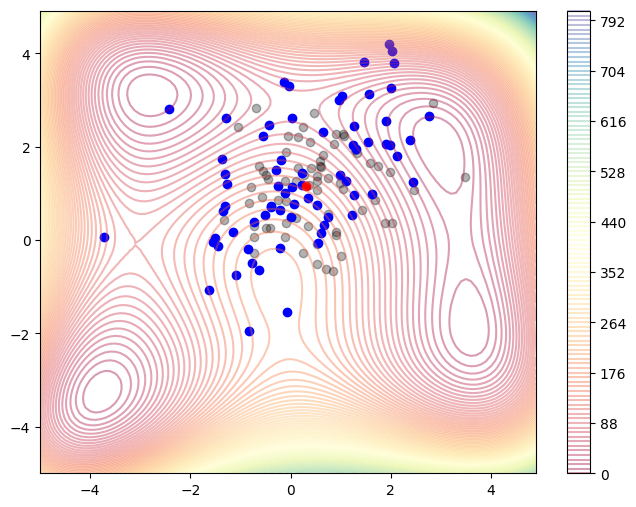

In [44]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.scatter(x_N[:, 0], x_N[:, 1], c='k', alpha=0.3)
plt.scatter(x_C[:, 0], x_C[:, 1], c='b')
plt.scatter(x[0], x[1], c='r')
fig.colorbar(cs)
plt.show()

<div class="alert alert-success">
    <h3>Exercise 2</h3>
    Simulate multiple covariance matrix updates from the same starting point, but using x_C (the transformed distribution) as the new population. Are the gradient directions sampled similar? How does the distribution change as the covariance matrix is updated multiple times?
</div>

## Step size control

In CMA-ES, the standard deviation $\sigma$ of the population distribution also updates automatically. A simple rule used before CMA-ES which demonstrates this concept is the one-fifth rule: 

<img src="https://github.com/d9w/evolution/raw/master/imgs/cmaes_onefifth.png" width="40%" height="auto">

The rule used in CMA-ES is a bit more complex; it estimates the recent evolutionary path and uses this estimate to "slow down" or "speed up" search.

<img src="https://github.com/d9w/evolution/raw/master/imgs/cmaes_pathlength.png" width="40%" height="auto">

<img src="https://github.com/d9w/evolution/raw/master/imgs/cmaes_pathlength2.png" width="40%" height="auto">

An effect of these two different updates, which are often referred to as two "evolutionary paths", is that CMA-ES will continue to search even after finding a local optima. $\sigma$ updates faster than $C$, narrowing in on selected areas or expanding on others, while the shape of the sampled distribution is refined over time.

## CMAES in practice

<img src="https://github.com/d9w/evolution/raw/master/imgs/cmaes.png" width="40%" height="auto">

To see CMA-ES in practice, we'll use the pycma package (https://github.com/CMA-ES/pycma). If you haven't installed it, do so here:

`pycma` is actively maintained by the CMA-ES author and has many more algorithm tricks and features than we've discussed here. [4] provides a good review of different CMA-ES modifications.

[4] Hansen, Nikolaus. "The CMA evolution strategy: a comparing review." Towards a new evolutionary computation. Springer, Berlin, Heidelberg, 2006. 75-102.

In [46]:
import cma
es = cma.CMAEvolutionStrategy(2 * [0], 0.1, {'popsize': 20, 'verb_disp': 1})

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 2 (seed=518933, Fri Apr 14 17:06:23 2023)


In [47]:
solutions = np.array(es.ask())
es.tell(solutions, [optf(x[0], x[1]) for x in solutions])
es.disp_annotation()
es.disp();

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 1.654775272737110e+02 1.0e+00 1.57e-01  2e-01  2e-01 0:00.0


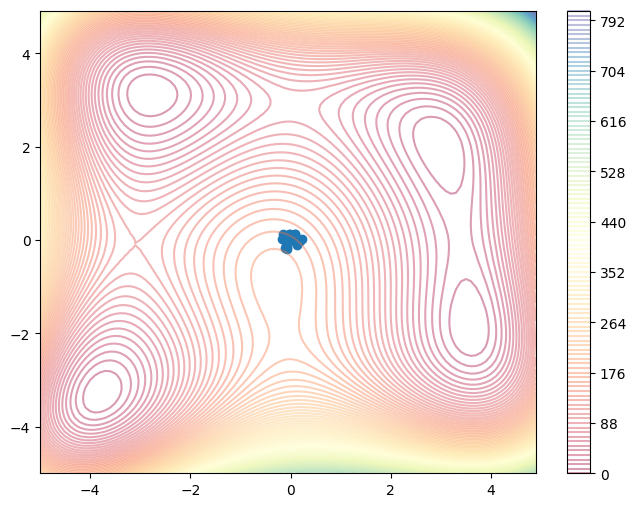

In [48]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot()
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.scatter(solutions[:, 0], solutions[:, 1])
fig.colorbar(cs)
plt.show()

In [49]:
def generation(i, es, ax):
    solutions = np.array(es.ask())
    es.tell(solutions, [optf(x[0], x[1]) for x in solutions])
    
    ax.clear()
    ax.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
    ax.scatter(solutions[:, 0], solutions[:, 1])
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.plot()

In [50]:
es = cma.CMAEvolutionStrategy(2 * [0], 0.1, {'popsize': 20})

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 2 (seed=603929, Fri Apr 14 17:10:34 2023)


RuntimeError: Requested MovieWriter (ffmpeg) not available

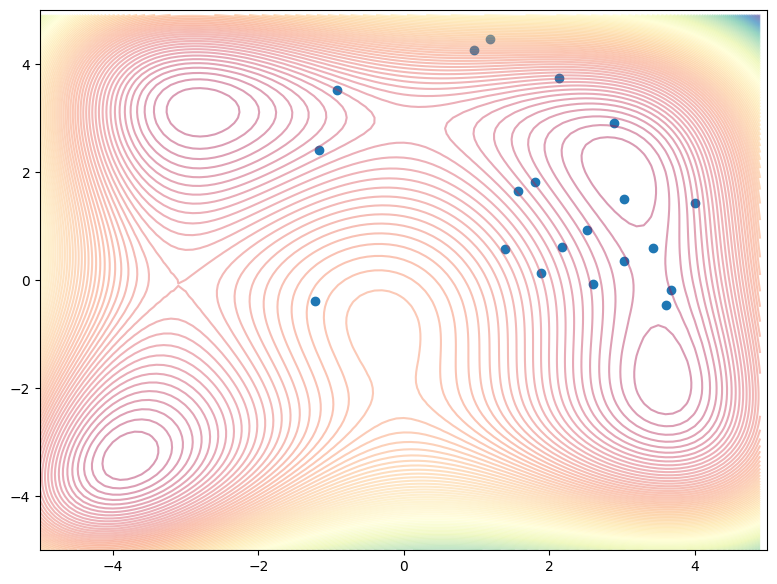

In [56]:
!pip install ffmpeg
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
fig.tight_layout()
frames = 20
animator = animation.FuncAnimation(fig, generation, fargs=(es, ax), frames=frames, interval=250, blit=False)
display.display(display.HTML(animator.to_html5_video()))
plt.close();

<div class="alert alert-success">
    <h3>Exercise 3</h3>
Change to the shifted rosenbrock function. Does CMA-ES get stuck in a local minimum? If so, are there parameters which allow it to find the global optimum?
</div>